# XGBoost

In [1]:
from Functions import get_result, get_best_threshold, plot_roc_curve, save_metrics_to_json, auto_cast
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from xgboost import XGBClassifier
import json
import mlflow
import optuna
import pandas as pd

In [2]:
mlflow.__version__

'3.6.0'

Load the datasets for training (remember they are scaled)

In [3]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

#### Hyperparameter Tuning

In [4]:
# Read the JSON file
with open('../config.json', 'r') as file:
    config = json.load(file)

# Set the tracking URI for logging using the values from the JSON file
mlflow.set_tracking_uri(uri=f"http://{config['host']}:{config['port']}")

client = mlflow.tracking.MlflowClient()

exp_name = "Credit_Card_Approval"
experiment = mlflow.get_experiment_by_name(exp_name)
exp_id = experiment.experiment_id
exp_id

'1'

In [5]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=exp_id)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1764788131496, experiment_id='1', last_update_time=1764788131496, lifecycle_stage='active', name='Credit_Card_Approval', tags={'mlflow.experimentKind': 'custom_model_development',
 'mlflow.note.content': 'This is the Credit Card Approval project. This '
                        'experiment contains the models for credit card '
                        'approval.',
 'project_name': 'credit-card-approval'}>

In [6]:
base_run_name = "xgboost"

In [7]:
prior_runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.runName LIKE '{base_run_name}%'",
    output_format="pandas",
    max_results=100,
)

print(f"Number of prior runs with base name '{base_run_name}': {len(prior_runs)}")

Number of prior runs with base name 'xgboost': 4


In [8]:
run_name = f"{base_run_name}_v{int(len(prior_runs))+1}"
run_name

'xgboost_v5'

In [9]:
# We'll need the count of each class for a hyperparameter
risk_count = Y_train.value_counts()

In [10]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),          # Number of trees
            'max_depth': trial.suggest_int('max_depth', 5, 75),                   # Maximum depth of a tree
            'learning_rate': trial.suggest_float('learning_rate', 0.1, 2.5),# Learning rate
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),                        # Fraction of samples to use per tree
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),                 # Fraction of features used per tree
            'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 100, 250, 500, 1000,    # Control the balance of positive and negative weights (for imbalance)
                                risk_count[0]/risk_count[1]]) # Typical value to consider
        }

        # Initialize the model
        model = XGBClassifier(**params, objective='binary:logistic', eval_metric='aucpr', random_state=42)

        # Train the model
        model.fit(X_train, Y_train)

        # Evaluate the model
        preds = model.predict(X_val)
        metrics = get_result(Y_val, preds)

        # Log the parameters
        mlflow.log_params(params)
        
        # Log the metrics
        mlflow.log_metrics(metrics)

        return metrics['f1']

In [11]:
artifact_path = "model"
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=exp_id, run_name=run_name) as parent_run:
    parent_run_id = parent_run.info.run_id
    # Initialize the Optuna study
    study = optuna.create_study(direction='maximize', study_name='XGBoost_Optimization')
    # Execute the hyperparameter optimization trials.
    study.optimize(objective, n_trials=20)

    # Log the best parameters found during the optimization
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_f1_score", study.best_value)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Credit Card Approval",
            "optimizer_engine": "optuna",
            "model_family": "XGBClassifier",
            "feature_set_version": 1,
            "version": int(len(prior_runs))+1
        }
    )

    model = XGBClassifier(**study.best_params, objective='binary:logistic', eval_metric='aucpr', random_state=42)
    model.fit(X_train, Y_train)

    # Log the final model
    model_info = mlflow.xgboost.log_model(model, 
                             artifact_path=artifact_path,
                             input_example=X_train.iloc[[0]]
                             )
    model_uri = model_info.model_uri

[I 2025-12-08 15:22:21,833] A new study created in memory with name: XGBoost_Optimization
[I 2025-12-08 15:22:31,673] Trial 0 finished with value: 0.0018214936247723133 and parameters: {'n_estimators': 732, 'max_depth': 40, 'learning_rate': 1.397482417348814, 'subsample': 0.8605207255623808, 'colsample_bytree': 0.7088358086637838, 'scale_pos_weight': 500}. Best is trial 0 with value: 0.0018214936247723133.


🏃 View run nimble-stag-84 at: http://127.0.0.1:8080/#/experiments/1/runs/9c689143a4144726a1087e0d1167f711
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:22:35,673] Trial 1 finished with value: 0.19090909090909092 and parameters: {'n_estimators': 311, 'max_depth': 5, 'learning_rate': 0.3984986536567343, 'subsample': 0.5109323284285701, 'colsample_bytree': 0.6407020987767984, 'scale_pos_weight': 250}. Best is trial 1 with value: 0.19090909090909092.


🏃 View run adorable-panda-687 at: http://127.0.0.1:8080/#/experiments/1/runs/e5f55f6821bf431ebfd4d2a9cdc674d0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:22:41,133] Trial 2 finished with value: 0.01904761904761905 and parameters: {'n_estimators': 288, 'max_depth': 64, 'learning_rate': 2.450877309997881, 'subsample': 0.5797784197251624, 'colsample_bytree': 0.6520306491599357, 'scale_pos_weight': 1}. Best is trial 1 with value: 0.19090909090909092.


🏃 View run kindly-dove-636 at: http://127.0.0.1:8080/#/experiments/1/runs/4c43136e2f364dcdbd3c0699749a2631
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:22:53,733] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 996, 'max_depth': 5, 'learning_rate': 1.3393663820597215, 'subsample': 0.8326399056805067, 'colsample_bytree': 0.602817031249901, 'scale_pos_weight': 500}. Best is trial 1 with value: 0.19090909090909092.


🏃 View run marvelous-shrike-663 at: http://127.0.0.1:8080/#/experiments/1/runs/81819fcc661345269bc4835ebea80773
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:22:58,933] Trial 4 finished with value: 0.007001166861143524 and parameters: {'n_estimators': 396, 'max_depth': 13, 'learning_rate': 2.2553763989703928, 'subsample': 0.5373800178276826, 'colsample_bytree': 0.7957912682463901, 'scale_pos_weight': 100}. Best is trial 1 with value: 0.19090909090909092.


🏃 View run gentle-whale-130 at: http://127.0.0.1:8080/#/experiments/1/runs/539843c69f0e4199af2db68d1e783a8c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:23:20,763] Trial 5 finished with value: 0.2732919254658385 and parameters: {'n_estimators': 786, 'max_depth': 66, 'learning_rate': 0.13182721144225332, 'subsample': 0.8795511456972658, 'colsample_bytree': 0.8842164381923474, 'scale_pos_weight': 500}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run charming-fawn-335 at: http://127.0.0.1:8080/#/experiments/1/runs/fc76f5fcce03436483d4bcee9977b035
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:23:34,563] Trial 6 finished with value: 0.0038585209003215433 and parameters: {'n_estimators': 941, 'max_depth': 40, 'learning_rate': 1.550212330040004, 'subsample': 0.6502166061794166, 'colsample_bytree': 0.8529700737420837, 'scale_pos_weight': 500}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run loud-zebra-236 at: http://127.0.0.1:8080/#/experiments/1/runs/70505d1da0634c6e9e3a9a80028de73f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:23:59,073] Trial 7 finished with value: 0.136986301369863 and parameters: {'n_estimators': 994, 'max_depth': 24, 'learning_rate': 1.0405931682479346, 'subsample': 0.8914372042688365, 'colsample_bytree': 0.9883093623282265, 'scale_pos_weight': 1}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run whimsical-cod-142 at: http://127.0.0.1:8080/#/experiments/1/runs/5a4ba950822a43669fcfa39606573493
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:24:05,413] Trial 8 finished with value: 0.0037367656217562797 and parameters: {'n_estimators': 433, 'max_depth': 62, 'learning_rate': 1.7230066802551567, 'subsample': 0.8176806539855512, 'colsample_bytree': 0.574218605442234, 'scale_pos_weight': 707.9454545454546}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run smiling-dove-386 at: http://127.0.0.1:8080/#/experiments/1/runs/228ae952fe094e0b9944c633880100ba
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:24:17,423] Trial 9 finished with value: 0.12290502793296089 and parameters: {'n_estimators': 506, 'max_depth': 12, 'learning_rate': 0.6687351270220933, 'subsample': 0.8130750425190609, 'colsample_bytree': 0.8960882360660238, 'scale_pos_weight': 100}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run hilarious-grouse-755 at: http://127.0.0.1:8080/#/experiments/1/runs/d948fbef088d47638890835a78319767
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:24:39,753] Trial 10 finished with value: 0.25477707006369427 and parameters: {'n_estimators': 707, 'max_depth': 73, 'learning_rate': 0.1785668094986117, 'subsample': 0.9939101465727918, 'colsample_bytree': 0.9682442875800664, 'scale_pos_weight': 1000}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run invincible-worm-618 at: http://127.0.0.1:8080/#/experiments/1/runs/91db90268a7a4635a3a64f34df896f28
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:25:08,423] Trial 11 finished with value: 0.26582278481012656 and parameters: {'n_estimators': 721, 'max_depth': 75, 'learning_rate': 0.15618460205163542, 'subsample': 0.9927019631416628, 'colsample_bytree': 0.9888703812187803, 'scale_pos_weight': 1000}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run overjoyed-auk-173 at: http://127.0.0.1:8080/#/experiments/1/runs/9e5a4ab8bf5341f68216333043cab55a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:25:32,333] Trial 12 finished with value: 0.2716049382716049 and parameters: {'n_estimators': 725, 'max_depth': 55, 'learning_rate': 0.7285165473638185, 'subsample': 0.9794118510860114, 'colsample_bytree': 0.8836576006451455, 'scale_pos_weight': 1000}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run likeable-cod-186 at: http://127.0.0.1:8080/#/experiments/1/runs/43e7415f92e147dfadd5a7fc408c22c8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:25:42,213] Trial 13 finished with value: 0.002886373111830923 and parameters: {'n_estimators': 823, 'max_depth': 55, 'learning_rate': 0.7784308573962972, 'subsample': 0.9330322396509814, 'colsample_bytree': 0.8761913024734309, 'scale_pos_weight': 1000}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run redolent-horse-433 at: http://127.0.0.1:8080/#/experiments/1/runs/419b10d9b2b342fcb81097b5092e7cfe
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:25:55,693] Trial 14 finished with value: 0.011759172154280339 and parameters: {'n_estimators': 593, 'max_depth': 51, 'learning_rate': 0.6002196491873779, 'subsample': 0.7162919929543672, 'colsample_bytree': 0.7823503635850738, 'scale_pos_weight': 250}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run calm-penguin-421 at: http://127.0.0.1:8080/#/experiments/1/runs/1fabfd20ac26435c98771765208fa2e3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:26:09,593] Trial 15 finished with value: 0.0006295247088448222 and parameters: {'n_estimators': 845, 'max_depth': 49, 'learning_rate': 1.018887508364507, 'subsample': 0.9394314757144263, 'colsample_bytree': 0.5037883612256633, 'scale_pos_weight': 707.9454545454546}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run whimsical-fly-637 at: http://127.0.0.1:8080/#/experiments/1/runs/77ec485a1f584adaada79ad4b4ef585e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:26:13,483] Trial 16 finished with value: 0.2631578947368421 and parameters: {'n_estimators': 111, 'max_depth': 64, 'learning_rate': 0.4270400403502458, 'subsample': 0.7444999403675875, 'colsample_bytree': 0.9097502605118601, 'scale_pos_weight': 500}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run masked-mule-772 at: http://127.0.0.1:8080/#/experiments/1/runs/247c56d794694cfda861c343997d2192
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:26:22,033] Trial 17 finished with value: 0.0024078979051288226 and parameters: {'n_estimators': 610, 'max_depth': 31, 'learning_rate': 0.9267272918549596, 'subsample': 0.9314495444514141, 'colsample_bytree': 0.8380408046771951, 'scale_pos_weight': 1000}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run crawling-grouse-18 at: http://127.0.0.1:8080/#/experiments/1/runs/28ecf4ee19a5486aaba5a3fe3316d794
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:26:48,123] Trial 18 finished with value: 0.25157232704402516 and parameters: {'n_estimators': 836, 'max_depth': 58, 'learning_rate': 0.38013285798050533, 'subsample': 0.783414283160009, 'colsample_bytree': 0.9323652898103619, 'scale_pos_weight': 500}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run merciful-dove-777 at: http://127.0.0.1:8080/#/experiments/1/runs/8c3b3eede631432eace0e5248b68c7fb
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-08 15:27:07,483] Trial 19 finished with value: 0.2625 and parameters: {'n_estimators': 675, 'max_depth': 46, 'learning_rate': 0.11246134228327798, 'subsample': 0.8757916258870676, 'colsample_bytree': 0.7532531924626924, 'scale_pos_weight': 1000}. Best is trial 5 with value: 0.2732919254658385.


🏃 View run popular-stork-876 at: http://127.0.0.1:8080/#/experiments/1/runs/15d09fa888674ac4995cd17a6e7d9597
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


2025/12/08 15:27:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred sche

🏃 View run xgboost_v5 at: http://127.0.0.1:8080/#/experiments/1/runs/100496897d4b469c994b7460e2e9f95b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


In [12]:
print(f'parent_run_id: {parent_run_id}')
print(f'model_uri: {model_uri}')

parent_run_id: 100496897d4b469c994b7460e2e9f95b
model_uri: models:/m-985685db8ce54dec90eb9b671bb05912


In [13]:
model_name = "Credit_Card_Approval_XGBoost"
result = mlflow.register_model(
    model_uri = model_uri, 
    name = model_name, 
    tags={
        "project": "Credit Card Approval",
        "model_family": "XGBClassifier"
    }
)

client.set_registered_model_alias(
    name=model_name,
    alias="challenger",
    version=result.version
)

Registered model 'Credit_Card_Approval_XGBoost' already exists. Creating a new version of this model...
2025/12/08 15:27:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit_Card_Approval_XGBoost, version 4
Created version '4' of model 'Credit_Card_Approval_XGBoost'.


In [14]:
runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'",
    output_format='pandas'
)

In [15]:
param_cols = [c for c in runs.columns if c.startswith("params.")]

display(runs[[
    'run_id', 
    'metrics.f1', 
    'metrics.recall', 
    'metrics.precision',
    'metrics.accuracy'
    ] + param_cols]
    .sort_values(by='metrics.f1', ascending=False)
    .head(10))

,run_id,metrics.f1,metrics.recall,metrics.precision,metrics.accuracy,params.scale_pos_weight,params.n_estimators,params.max_depth,params.subsample,params.learning_rate,params.colsample_bytree
14,fc76f5fcce03436483d4bcee9977b035,0.273292,0.458333,0.194690,0.996571,500,786,66,0.8795511456972658,0.13182721144225332,0.8842164381923474
7,43e7415f92e147dfadd5a7fc408c22c8,0.271605,0.458333,0.192982,0.996541,1000,725,55,0.9794118510860114,0.7285165473638185,0.8836576006451455
8,9e5a4ab8bf5341f68216333043cab55a,0.265823,0.437500,0.190909,0.996600,1000,721,75,0.9927019631416628,0.15618460205163542,0.9888703812187803
3,247c56d794694cfda861c343997d2192,0.263158,0.416667,0.192308,0.996717,500,111,64,0.7444999403675875,0.4270400403502458,0.9097502605118601
0,15d09fa888674ac4995cd17a6e7d9597,0.262500,0.437500,0.187500,0.996541,1000,675,46,0.8757916258870676,0.11246134228327798,0.7532531924626924
9,91db90268a7a4635a3a64f34df896f28,0.254777,0.416667,0.183486,0.996571,1000,707,73,0.9939101465727918,0.1785668094986117,0.9682442875800664
1,8c3b3eede631432eace0e5248b68c7fb,0.251572,0.416667,0.180180,0.996512,500,836,58,0.783414283160009,0.38013285798050533,0.9323652898103619
18,e5f55f6821bf431ebfd4d2a9cdc674d0,0.190909,0.437500,0.122093,0.994783,250,311,5,0.5109323284285701,0.3984986536567343,0.6407020987767984
12,5a4ba950822a43669fcfa39606573493,0.136986,0.104167,0.200000,0.998153,1,994,24,0.8914372042688365,1.0405931682479346,0.9883093623282265
10,d948fbef088d47638890835a78319767,0.122905,0.458333,0.070968,0.990797,100,506,12,0.8130750425190609,0.6687351270220933,0.8960882360660238


From the above results we see that all the models with 1.0 scale_pos_weight lays in the lower end compared to the higher ones. Since we have a imbalanced dataset, this make good sense.

Lets take the parameters that resulted in the best performance and test it on our test set and see how well it is doing.

In [16]:
loaded_model = mlflow.xgboost.load_model(model_uri)

In [17]:
# Predict on the val set
val_predictions = loaded_model.predict_proba(X_val)[:, 1]

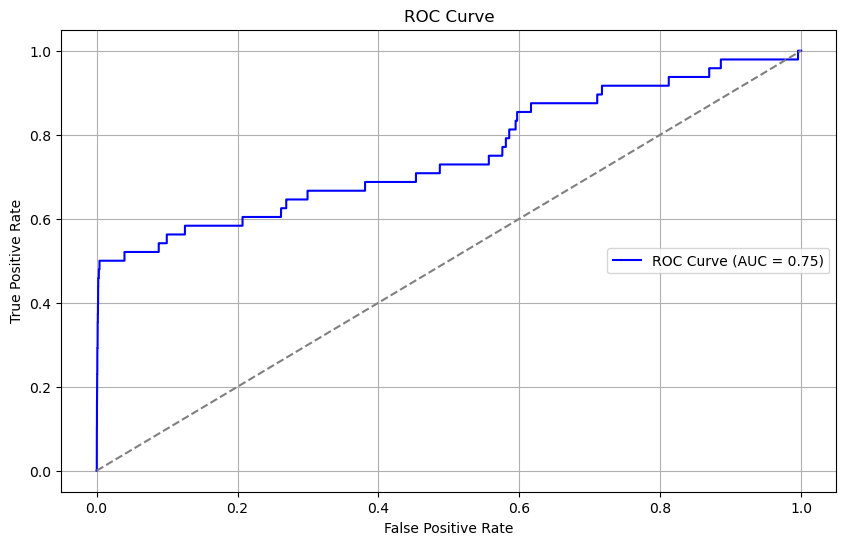

0.7533778495254867

In [18]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:74: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


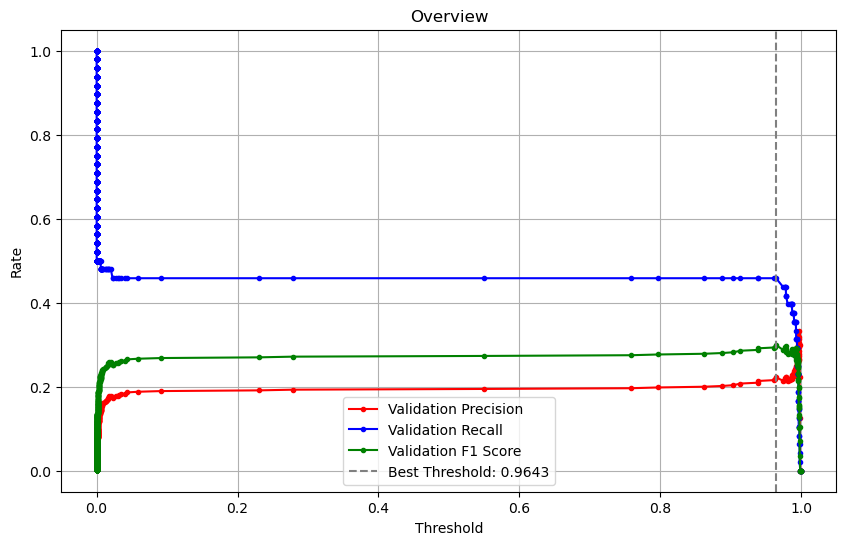

0.9643098

In [19]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)
client.log_param(parent_run_id, 'best_threshold', best_threshold)

In [20]:
# Predict on the test set
test_predictions = loaded_model.predict_proba(X_test)[:, 1]

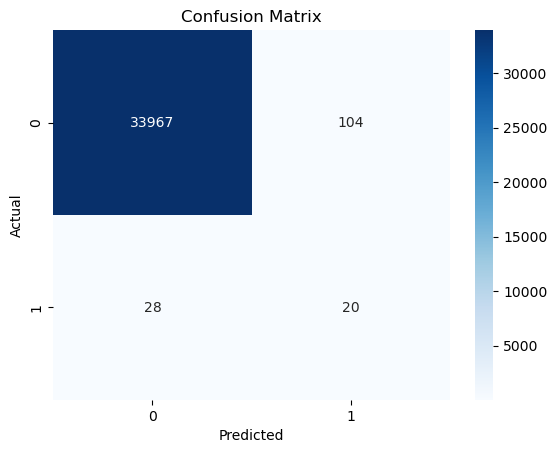

Accuracy     = 1.0
Recall       = 0.42
Precision    = 0.16
F1           = 0.23


In [21]:
result_1 = get_result(Y_test, test_predictions, best_threshold, visualize=True)

Lets see if it's better than the current champion model (if this is not the first time running)

-- Confusion matrix for champion model --


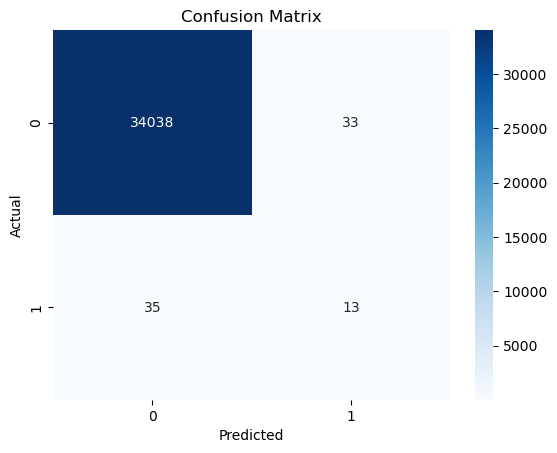

Accuracy     = 1.0
Recall       = 0.27
Precision    = 0.28
F1           = 0.28

Current champion remains


In [22]:
try:
    champ_model = mlflow.xgboost.load_model(f"models:/{model_name}@champion")
    champ_predictions = champ_model.predict_proba(X_test)[:, 1]
    print('-- Confusion matrix for champion model --')
    champ_result = get_result(Y_test, champ_predictions, best_threshold, visualize=True)
    if result_1['f1'] > champ_result['f1']:
        print('')
        print('Promoting new model to champion status')
        # Get champion model version
        champ_version = client.get_model_version_by_alias(
            name=model_name,
            alias="champion"
        )
        # Delete existing champion alias
        client.delete_registered_model_alias(
            name=model_name,
            alias="champion"
        )
        # Set former champion to previous-champion alias
        client.set_registered_model_alias(
            name=model_name,
            version=champ_version.version,
            alias="previous-champion"
        )
        # Promote new model to champion
        client.delete_registered_model_alias(
            name=model_name,
            alias="challenger"
        )
        client.set_registered_model_alias(
            name=model_name,
            version=result.version,
            alias="champion"
        )
    else: # Challenger model rejected
        print('')
        print('Current champion remains')
        client.delete_registered_model_alias(
            name=model_name,
            alias="challenger"
        )
        client.set_registered_model_alias(
            name=model_name,
            version=result.version,
            alias="rejected"
        )
except Exception:
    print('No champion model')
    print('Promoting current model to champion status')
    client.delete_registered_model_alias(
            name=model_name,
            alias="challenger"
        )
    client.set_registered_model_alias(
        name=model_name,
        version=result.version,
        alias="champion"
    )

### Train on both training and validation set

Lets merge the training and validation set and predict on the test set to see if the model can perform better with more training data. We'll keep the best threshold, since the model now have seen the data to construct the best threshold. However, I do not think the threshold can get much closer to 1.

In [ ]:
best_run = mlflow.get_run(parent_run_id)
best_params = best_run.data.params
best_params = {k: auto_cast(v) for k, v in best_params.items()}
best_params

{'n_estimators': 521,
 'max_depth': 24,
 'learning_rate': 0.592163786154168,
 'subsample': 0.9953333785206998,
 'colsample_bytree': 0.6081573856287199,
 'scale_pos_weight': 1000}

In [ ]:
# Initialize the RandomForestClassifier with the best hyperparameters from the tuning phase
xgb = XGBClassifier(**best_params, eval_metric="aucpr", random_state=42)

In [ ]:
# Train the model
xgb.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6081573856287199, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.592163786154168,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=24, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=521, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Predict on the val set
val_predictions = xgb.predict_proba(X_val)[:, 1]

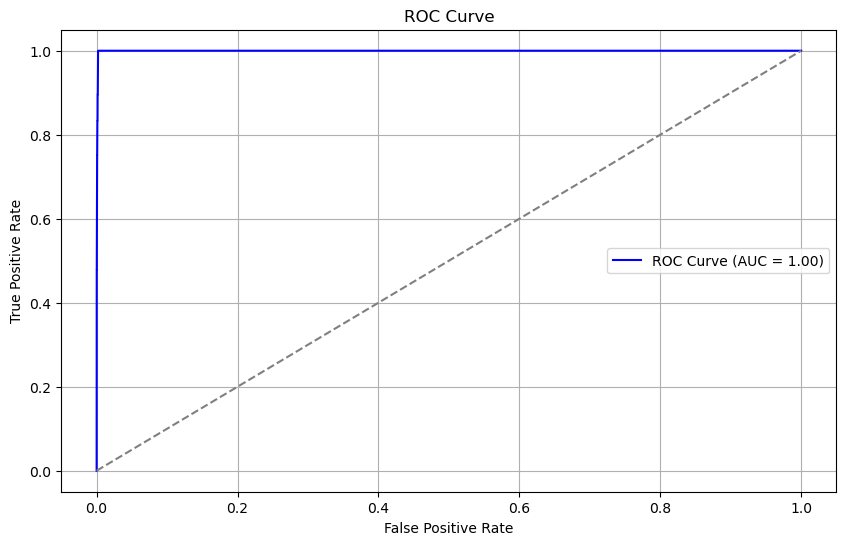

0.9995426083553468

In [ ]:
plot_roc_curve(Y_val, val_predictions)

It does perfect on the ROC Curve, which is not surprising, since the model has been trained on the data

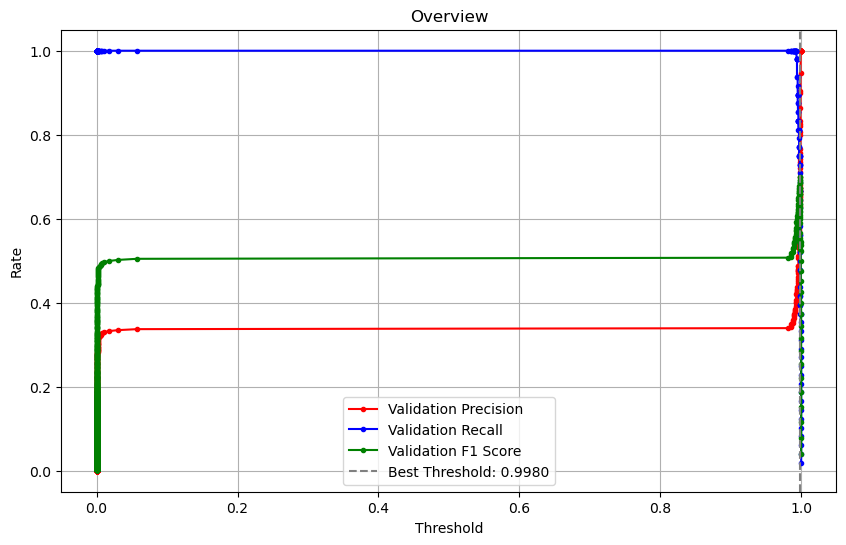

In [ ]:
_ = get_best_threshold('Validation', Y_val, val_predictions)

In [ ]:
# Predict on the test set
test_predictions = xgb.predict_proba(X_test)[:, 1]

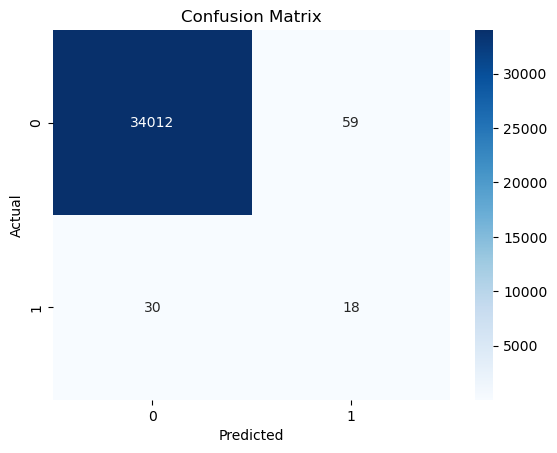

Accuracy     = 1.0
Recall       = 0.38
Precision    = 0.23
F1           = 0.29


In [ ]:
result_2 = get_result(Y_test, test_predictions, best_threshold, visualize=True)

In [ ]:
if result_2['f1'] > result_1['f1']:
    print('By training our model on more data, we achived a higher performance on the F1 score')
else:
    print('The first model we found, through hyperparameter tuning, is still our best model on the F1 score.')
    print('It had the following scores:')
    print('Recall       =', round(result_1['recall'], 2))
    print('Precision    =', round(result_1['precision'], 2))
    print('F1           =', round(result_1['f1'], 2))

By training our model on more data, we achived a higher performance on the F1 score
